## BTC Buy Signals PyTorch demo

by Sergey Kuznetsov 

(github: @mousehead, email: sk@imap.cc)

***Notice***: this is a research project only to explore time series and play with PyTorch. If I were you I would not bring it to production. There's some discussion at the end of this notebook

#### Objective:
given only only BTCUSD price history with a time resolution of 1 minute, build a neural network and a trading algorithm on top of it that would predict whether it's a good idea to briefly buy BTC (for 3 minutes) and then immediately sell it.

#### Limitations:
no data other than the price data itself is used, not even volume or the weekday. moreover, the model only takes into the account a sequence of 60 (i.e. 1 hour) when making a prediction.

#### Precautions:
the most important thing is to split and process data correctly to avoid any forward-looking (i.e. looking into the future) data leaks.

## Importing everything

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from fastai.data.core import DataLoaders
from matplotlib import pyplot as plt
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'torch=={torch.__version__}')
print(f'device=={device}')

torch==2.0.1+cu118
device==cuda


## Loading data

In [5]:
fpaths = ['drive/MyDrive/BTC-2021min.csv',
          'drive/MyDrive/BTC-2020min.csv',
          'drive/MyDrive/BTC-2019min.csv',
          'drive/MyDrive/BTC-2018min.csv',
          'drive/MyDrive/BTC-2017min.csv'
          ]

dfs = [pd.read_csv(fpath) for fpath in fpaths]
df = pd.concat(dfs)
df.reset_index(inplace=True, drop=True)
df = df.iloc[reversed(df.index)].reset_index(inplace=False)
df.shape

(2675301, 10)

In [6]:
df.head()

,index,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,2675300,1483228860,2017-01-01 00:01:00,BTC/USD,966.34,966.34,966.34,966.34,7.610000,7353.847400
1,2675299,1483228920,2017-01-01 00:02:00,BTC/USD,966.16,966.37,966.16,966.37,8.087376,7815.397864
2,2675298,1483228980,2017-01-01 00:03:00,BTC/USD,966.37,966.37,966.37,966.37,0.000000,0.000000
3,2675297,1483229040,2017-01-01 00:04:00,BTC/USD,966.37,966.37,966.37,966.37,0.000000,0.000000
4,2675296,1483229100,2017-01-01 00:05:00,BTC/USD,966.43,966.43,966.43,966.43,0.107000,103.408010


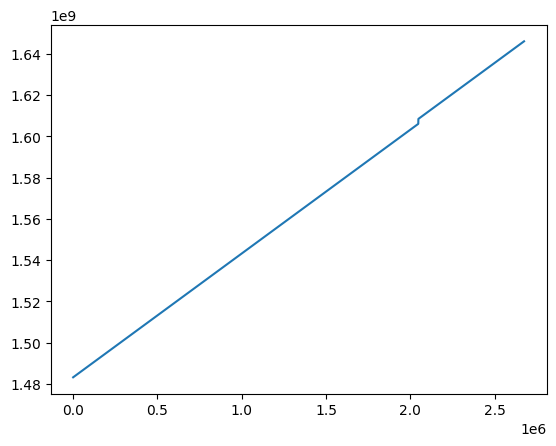

In [7]:
plt.plot(df['unix'])
# there's a time gap, but this won't be an issue and will only ruin one batch of data 
# out of thousands of batches
# so for a baseline solution we won't bother mitigating it
# and will consider time to be linear

## Designing the target

In [143]:
# we want to predict whether the price will rise in 3 minutes
# (which is 3 rows for this dataset)
SELL_LAG = 3

In [145]:
# up==1 if price has grown since 3 minutes ago
df['up'] = ((df['open']/df['open'].shift(+SELL_LAG)) > 1.000).astype(int)

# strong_up==1 if price has grown since 3 minutes ago SIGNIFICANTLY enough
df['strong_up'] = ((df['open']/df['open'].shift(+SELL_LAG)) > 1.0012).astype(int)

# as you would expect, `up` is somewhat evenly distributed but `strong_up` is rare 
print(df['up'].mean(), df['strong_up'].mean())

0.49661365207129965 0.17444130585679893


In [215]:
# NOTE: shift(+3) does not bring any leaks from the future, to the contrary, 
# shift(+3) brings up data from the past, specifically 3 minutes earlier

## Train-validation-test split

In [216]:
# we have no choice but to split them sequentially, so that valid goes AFTER the train, 
# and test goes AFTER the valid

# the key thing we want to avoid here is the forward-looking leaks
# this means ensuring the model never sees the data from the future while learning on the past
# but also that the batches are constructed properly (more on that later)

print(f'total rows: {df.shape[0]}')  # ~2.67 mln

total rows: 2675301


In [147]:
VALID_STARTS = 1800*1000
TEST_STARTS = 2300*1000

df_train = df.iloc[:VALID_STARTS]
df_valid = df.iloc[VALID_STARTS:TEST_STARTS]
df_test = df.iloc[TEST_STARTS:]

df_train.shape, df_valid.shape, df_test.shape

((1800000, 12), (500000, 12), (375301, 12))

In [148]:
# of course, this makes distributions (even the distribution of the target variables)
# uneven between the splits

print(f"{df_train['up'].mean():.4f}, {df_valid['up'].mean():.4f}, {df_test['up'].mean():.4f}")
print(f"{df_train['strong_up'].mean():.4f}, {df_valid['strong_up'].mean():.4f}, {df_test['strong_up'].mean():.4f}")

# but we'll have to work with this,
# it is still the only sensible way to split, forward-looking leaks are unacceptable

0.4955, 0.4995, 0.4984
0.1773, 0.1713, 0.1650


## Writing our own dataset with overloaded obj[i] and len(obj)

In [149]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, y1, t, sequence_length, lag):
        self.X = X      # sequence features to feed the model
        self.y = y      # target to predict ("strong_up" in our case)
        self.y1 = y1    # additional target to evaluate strategy ("up" in our case)
        self.t = t      # unix time stored just in case
        self.sequence_length = sequence_length
        self.lag = lag  # we're gonna predict the target from the nearest future ("lag" minutes into the future)

    def __len__(self):
        return len(self.X) - self.sequence_length - self.lag  # ensure we can create complete sequences

    def __getitem__(self, index):
        return (
            self.X[index:index+self.sequence_length],
            # note that we're returning the y corresponding to the last element of the sequence,
            # but this means that we're predicting whether the price will increase in 3 minutes since that last elements,
            self.y[index+self.sequence_length+self.lag-1],
            )

In [150]:
sample_price = pd.Series([10, 10, 10, 10, 9, 9, 9, 12, 12, 12, 12, 10, 11, 11, 11, 12, 11, 8, 9, 9, 9])
sample_up = ((sample_price/sample_price.shift(+SELL_LAG)) > 1.001).astype(int)
sample_X = torch.tensor(sample_price.to_numpy().reshape(-1, 1))
sample_Y = torch.tensor(sample_up.to_numpy())
sample_tsds = TimeSeriesDataset(X=sample_X,
                                y=sample_Y,
                                y1=sample_Y,   #  these two won't be used in this example, but we have to pass them
                                t=sample_Y,    #  these two won't be used in this example, but we have to pass them
                                sequence_length=4, 
                                lag=SELL_LAG)

print(np.vstack([sample_X.flatten().numpy(), sample_Y.numpy()]).transpose())

[[10  0]
 [10  0]
 [10  0]
 [10  0]
 [ 9  0]
 [ 9  0]
 [ 9  0]
 [12  1]
 [12  1]
 [12  1]
 [12  0]
 [10  0]
 [11  0]
 [11  0]
 [11  1]
 [12  1]
 [11  0]
 [ 8  0]
 [ 9  0]
 [ 9  0]
 [ 9  1]]


In [151]:
# 1 in the right column means the price has gone up, so far the data makes sense
# let's se how it's gonna be batched

In [152]:
sample_dl = DataLoader(sample_tsds, batch_size=8)
for xb, yb in sample_dl:
    print(xb, yb)
    break

tensor([[[10],
         [10],
         [10],
         [10]],

        [[10],
         [10],
         [10],
         [ 9]],

        [[10],
         [10],
         [ 9],
         [ 9]],

        [[10],
         [ 9],
         [ 9],
         [ 9]],

        [[ 9],
         [ 9],
         [ 9],
         [12]],

        [[ 9],
         [ 9],
         [12],
         [12]],

        [[ 9],
         [12],
         [12],
         [12]],

        [[12],
         [12],
         [12],
         [12]]]) tensor([0, 1, 1, 1, 0, 0, 0, 0])


In [153]:
# reminder: the full price history is [10, 10, 10, 10, 9, 9, 9, 12, 12, 12, 12, 10, 11, 11, 11, 12, 11, 8, 9, 9, 9]
# this may not be very comprehensible, but this is what happens here:

# 1. the first sequence of len 4: [10,10,10,10], does NOT lead to a price increase 3 items after this sequence's last item
# [10*, 10*, 10*, 10*, 9, 9, 9†, 12, 12, 12, 12, 10, 11, 11, 11, 12, 11, 8, 9, 9, 9]

# 2. the next sequence of len 4: [10,10,10,9], DOES lead to an increase 3 items later:
# [10, 10*, 10*, 10*, 9*, 9, 9, 12†, 12, 12, 12, 10, 11, 11, 11, 12, 11, 8, 9, 9, 9]

# thus, I verified the correct behavior of TimeSeriesDataset

## Creating datasets and dataloaders for our data

In [154]:
SEQUENCE_LEN = 60  # an hour
BATCH_SIZE = 256  # our GPU can afford this

train_tsds = TimeSeriesDataset(X=df_train['open'].to_numpy(dtype=np.float32).reshape(-1, 1), 
                               y=df_train['strong_up'].to_numpy(dtype=np.float32),  # training model to predict this
                               y1=df_train['up'].to_numpy(dtype=np.float32),   # for evaluation purposes only, not training on this
                               t=df_train['unix'].to_numpy(dtype=np.int32), 
                               sequence_length=SEQUENCE_LEN,
                               lag=SELL_LAG)
train_dl = DataLoader(train_tsds, batch_size=BATCH_SIZE)

valid_tsds = TimeSeriesDataset(X=df_valid['open'].to_numpy(dtype=np.float32).reshape(-1, 1), 
                               y=df_valid['strong_up'].to_numpy(dtype=np.float32),
                               y1=df_valid['up'].to_numpy(dtype=np.float32),
                               t=df_valid['unix'].to_numpy(dtype=np.int32), 
                               sequence_length=SEQUENCE_LEN,
                               lag=SELL_LAG)
valid_dl = DataLoader(valid_tsds, batch_size=BATCH_SIZE)

test_tsds = TimeSeriesDataset(X=df_test['open'].to_numpy(dtype=np.float32).reshape(-1, 1), 
                               y=df_test['strong_up'].to_numpy(dtype=np.float32),
                               y1=df_test['up'].to_numpy(dtype=np.float32),
                               t=df_test['unix'].to_numpy(dtype=np.int32), 
                               sequence_length=SEQUENCE_LEN,
                               lag=SELL_LAG)
test_dl = DataLoader(test_tsds, batch_size=BATCH_SIZE)

In [155]:
for xb, yb in train_dl:
    print(xb, yb)
    break

tensor([[[966.3400],
         [966.1600],
         [966.3700],
         ...,
         [966.6000],
         [966.6000],
         [966.6000]],

        [[966.1600],
         [966.3700],
         [966.3700],
         ...,
         [966.6000],
         [966.6000],
         [966.6000]],

        [[966.3700],
         [966.3700],
         [966.4300],
         ...,
         [966.6000],
         [966.6000],
         [966.6000]],

        ...,

        [[963.1500],
         [963.1500],
         [963.6400],
         ...,
         [963.0100],
         [963.0100],
         [963.0000]],

        [[963.1500],
         [963.6400],
         [963.6400],
         ...,
         [963.0100],
         [963.0000],
         [963.0000]],

        [[963.6400],
         [963.6400],
         [963.6400],
         ...,
         [963.0000],
         [963.0000],
         [963.0000]]]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [156]:
xb.shape, yb.shape

(torch.Size([256, 60, 1]), torch.Size([256]))

In [157]:
# looks legit

## Defining a model

In [158]:
from torch import nn
from torch.nn import functional as F
!pip install torchviz
from torchviz.dot import make_dot, resize_graph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [159]:
class NetV2(nn.Module):
    def __init__(self):
        super(NetV2, self).__init__()
        self.one = torch.tensor(1., requires_grad=False)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, stride=1, bias=True)
        self.pool1 = nn.MaxPool1d(3, stride=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=1, bias=True)
        self.pool2 = nn.MaxPool1d(3, stride=2)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, bias=True)
        self.pool3 = nn.MaxPool1d(3, stride=2)
        self.fc1 = nn.Linear(64*4, 64, bias=True)
        self.fc2 = nn.Linear(64, 16, bias=True)
        self.fc3 = nn.Linear(16, 1, bias=True)
        
    def forward(self, xb):
        x = xb
        x = (x / x[:,0,0].view(-1, 1, 1)) - self.one   # this might require some explanation, see "normalization" later
        x = x.transpose(1,2)
        x = self.conv1(x)
        x = F.leaky_relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.leaky_relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.leaky_relu(x)
        x = self.pool3(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        return x

In [160]:
# NORMALIZATION:
# x = (x / x[:,0,0].view(-1, 1, 1)) - self.one
# this line achieves two things:
# 1. scales the sequence (by dividing each sequence by its first item)
# 2. centers the sequence (by subtracting 1)

# 1. SCALING:
# here I follow the assumption that the percentage change of the price is what really matters
# e.g. BTCUSD and ETHUSD often behave similarly despite the BTC price being an order of magnitude larger
# by letting go of the scale we turn [46339,   46365,   46505,   46487,   46383,   46221]
#                               into [1.   , 1.00056, 1.00358, 1.00319, 1.00095, 0.99745]
# which allows the model that was trained on 2018's BTCUSD==3k 
# to perform well on 2021's data where BTCUSD shoots up to 60k,
# because the general patterns stay the same

# 2. CENTERING
# [1.   , 1.00056, 1.00358, 1.00319, 1.00095, 0.99745..] is a great way 
# to represent the pattern of the price change, however it's not so great for a neural network 
# to feed exclusively positive values centered around some positive constant like 1.
# by subtracting 1., we get a [ 0.     ,  0.00056,  0.00358,  0.00319,  0.00095, -0.00255..] sequence
# which may look very similar for a human, but could make a world of difference for the overall convergence

In [161]:
net = NetV2()
for param in list(net.parameters()):
    print(param.shape)

torch.Size([16, 1, 5])
torch.Size([16])
torch.Size([32, 16, 5])
torch.Size([32])
torch.Size([64, 32, 3])
torch.Size([64])
torch.Size([64, 256])
torch.Size([64])
torch.Size([16, 64])
torch.Size([16])
torch.Size([1, 16])
torch.Size([1])


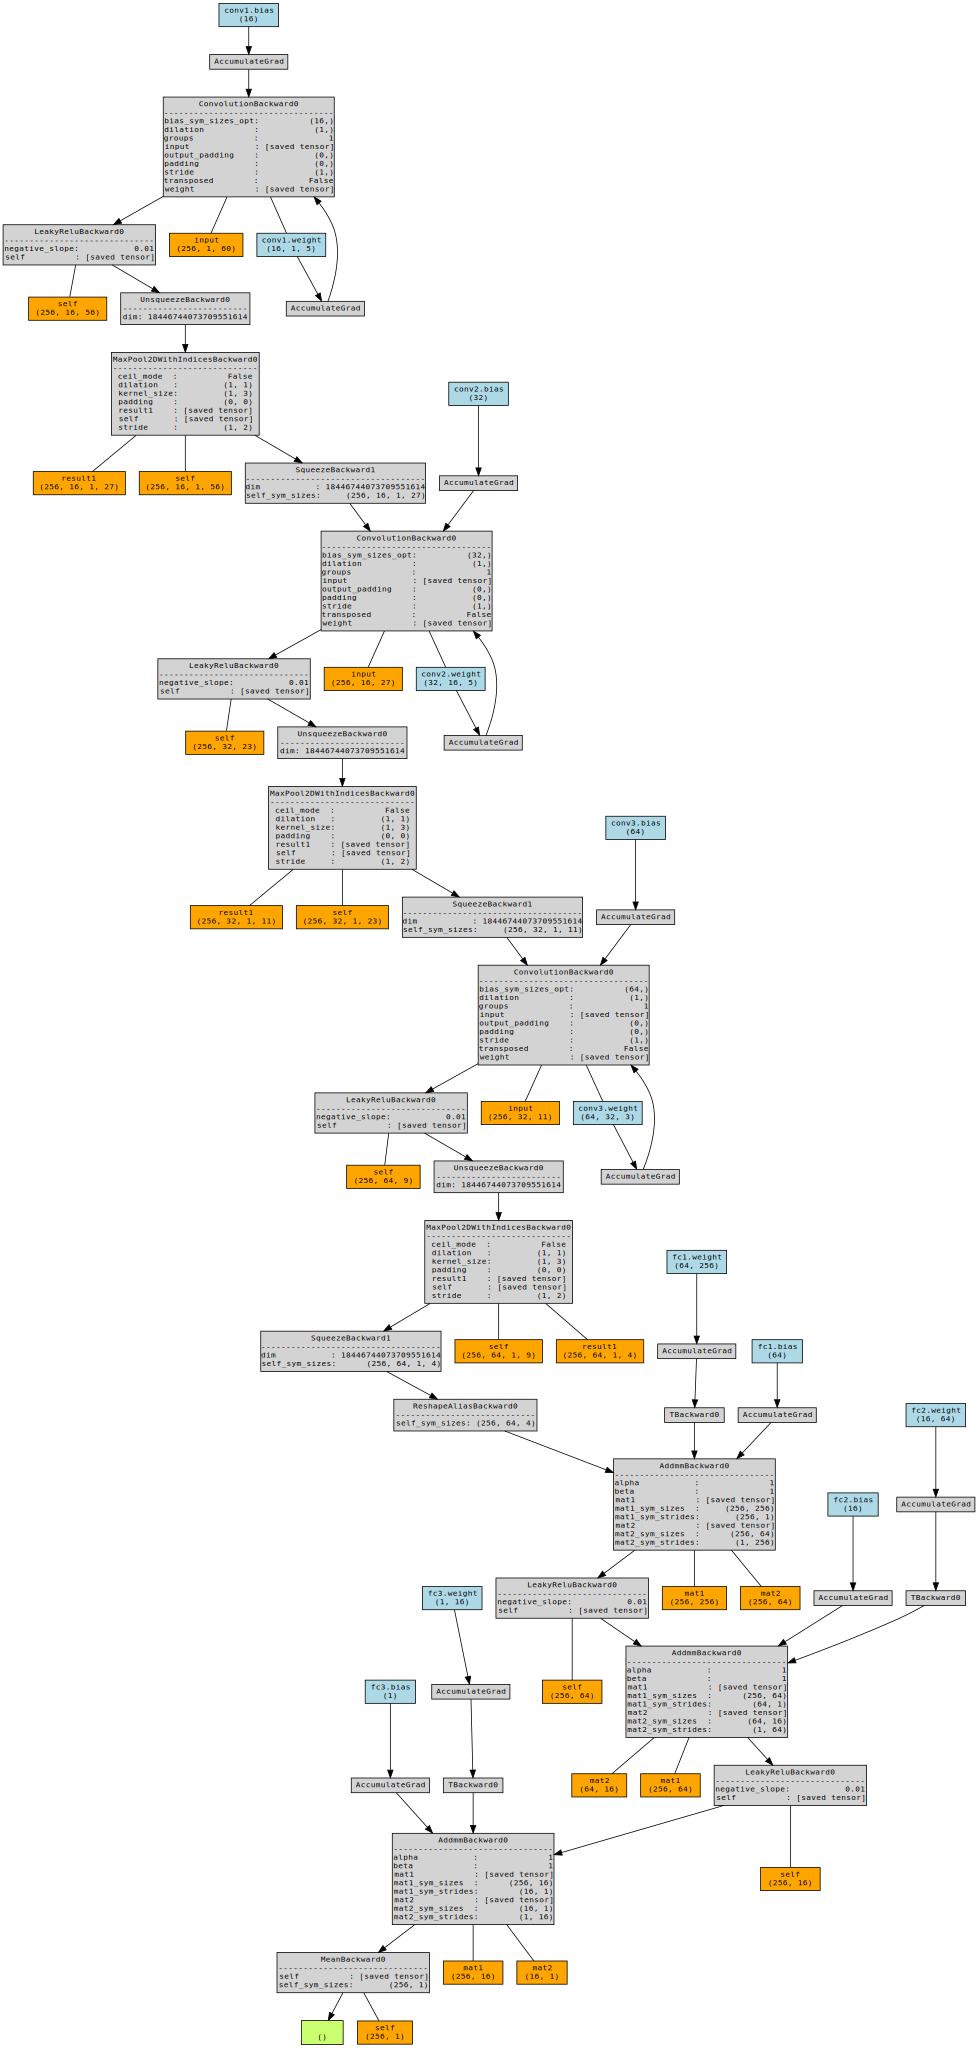

In [162]:
# the computation graph looks like this
for xb, yb in train_dl:
    break
ypred = net.forward(xb)
graph = make_dot(ypred.mean(), params=dict(net.named_parameters()), show_attrs=True, show_saved=True)
resize_graph(graph, size_per_element=0.002, min_size=50)
graph

## Validation functions

In [163]:
# this function is used to get all y_true and y_pred for a certain dataloader
# as numpy arrays. this can be useful to caclculate
# some metrics from sklearn that don't support batching or tensors

def get_all_targets_and_preds(model, dataloader):
    model.eval()  # setting model to eval mode
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in dataloader:
            if device.type != 'cpu':
                xb, yb = xb.to(device), yb.to(device)            
            ypred = net.forward(xb).reshape(-1)
            all_preds.append(np.array(ypred.cpu()))
            all_targets.append(np.array(yb.cpu()))
    model.train()  # back to train mode
    return np.hstack(all_targets), np.hstack(all_preds)

In [164]:
# this function computes a loss_fn over a certain dataloader with a given model
# this is important in the training loop to monitor the validation loss

def evaluate_model(model, dataloader, loss_fn):
    total_loss = 0.
    total_batches = 0
    model.eval()
    with torch.no_grad():
        for xb, yb in dataloader:
            if device.type != 'cpu':
                xb, yb = xb.to(device), yb.to(device)
            ypred = model.forward(xb).reshape(-1)
            loss = loss_fn(ypred, yb)
            total_loss += loss.item()
            total_batches += 1
    model.train()
    return total_loss/total_batches

In [165]:
# "strong_up" (which is our target) isn't distributed evenly
# we have to assign higher weights to 1s than to 0s,
# otherwise the model may learn to predict 0s always
positive_weight = train_tsds.y.mean()  # we're only using train, no leak here
positive_weight = torch.tensor((1.-positive_weight) / positive_weight)
print(positive_weight)

tensor(4.6401, dtype=torch.float64)


In [166]:
# everything more or less standard here, feel free to ask any questions

import sys
from torch.optim import Adam, SGD

verbose = False

net = NetV2().to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=positive_weight).to(device)
optimizer = Adam(params=net.parameters(), lr=0.005)
epochs = []
train_losses = []
valid_losses = []
n_epochs = 30

for epoch in range(n_epochs):
    batch_i = 0
    cumulative_loss = 0.
    for xb, yb in train_dl:
        if device.type != 'cpu':
            xb, yb = xb.to(device), yb.to(device)
        ypred = net.forward(xb).reshape(-1)
        loss = loss_fn(ypred, yb)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        cumulative_loss += loss.item()
        batch_i += 1
        if batch_i % 250 == 0 and verbose:
            print(f'{batch_i} batches, loss={cumulative_loss/batch_i:.6f}')
        if batch_i % 500 == 0 and not verbose:
            print('.', end='')
            sys.stdout.flush()
    # train_loss = evaluate_model(net, train_dl, loss_fn=loss_fn)
    train_loss = cumulative_loss / batch_i
    valid_loss = evaluate_model(net, valid_dl, loss_fn=loss_fn)
    print(f'\nepoch #{epoch}, train_loss={train_loss:.6f}, valid_loss={valid_loss:.6f}')
    epochs.append(epoch)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

..............
epoch #0, train_loss=1.073804, valid_loss=1.123382
..............
epoch #1, train_loss=1.056630, valid_loss=1.103870
..............
epoch #2, train_loss=1.047140, valid_loss=1.082533
..............
epoch #3, train_loss=1.036537, valid_loss=1.054986
..............
epoch #4, train_loss=1.034260, valid_loss=1.056459
..............
epoch #5, train_loss=1.040159, valid_loss=1.046743
..............
epoch #6, train_loss=1.031607, valid_loss=1.047067
..............
epoch #7, train_loss=1.030399, valid_loss=1.043261
..............
epoch #8, train_loss=1.028788, valid_loss=1.052492
..............
epoch #9, train_loss=1.027687, valid_loss=1.036377
..............
epoch #10, train_loss=1.027805, valid_loss=1.042877
..............
epoch #11, train_loss=1.028480, valid_loss=1.038197
..............
epoch #12, train_loss=1.026160, valid_loss=1.042472
..............
epoch #13, train_loss=1.026345, valid_loss=1.048390
..............
epoch #14, train_loss=1.026252, valid_loss=1.037835
.....

In [167]:
torch.save(net, 'drive/MyDrive/net_v2_b5.pt')

In [ ]:
# net = torch.load('drive/MyDrive/net_v2_b2.pt')

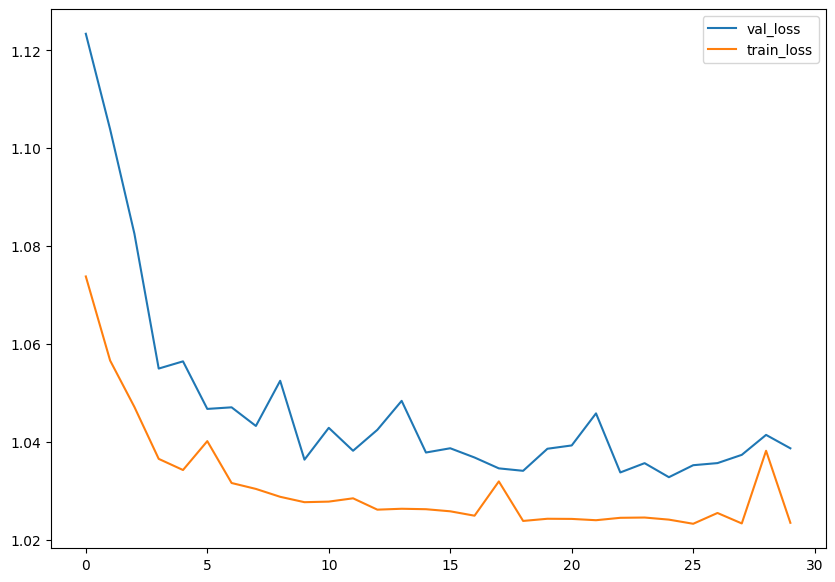

In [168]:
# training history
plt.figure(figsize=(10,7))
plt.plot(epochs, [x for x in valid_losses], label='val_loss')
plt.plot(epochs, [x for x in train_losses], label='train_loss')
plt.legend();

In [169]:
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7,7))
    plt.plot([0, 1], [0, 1], '--', color='darkgrey', label='Chance level (AUC = 0.50)')
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [170]:
valid_targets, valid_preds = get_all_targets_and_preds(model=net.to('cuda'), dataloader=valid_dl)

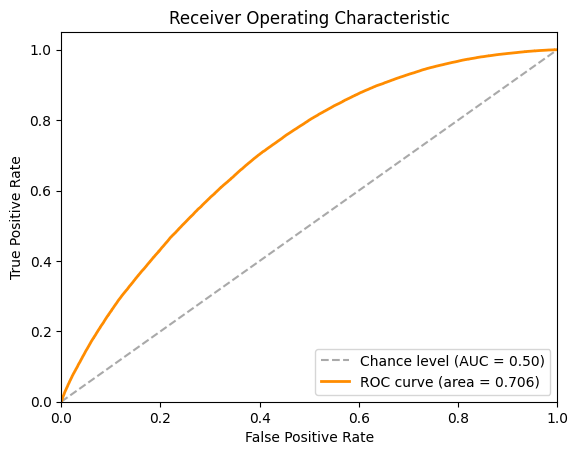

In [171]:
plot_roc_auc(y_true=valid_targets, y_pred=valid_preds)

In [195]:
## it's not much, but it's honest work

In [207]:
top_k = 5000
top_indices = np.argsort(valid_preds)[-top_k:]
cnt_strong_up = 0
for ix in top_indices:
    cnt_strong_up += valid_tsds[ix][1]
print(cnt_strong_up/top_k, valid_tsds.y.mean())
# basically, there's an event that has a 17% probability to occur,
# but given the model's signal, this becomes a conditional probability of 44%
# which sounds better than random, right? this can't be just noise 

0.4448 0.171252


In [208]:
# let's see the distribution of predicted logits
np.sort(valid_preds)[-5000:].min(), np.sort(valid_preds)[-500:].min(), np.sort(valid_preds)[-50:].min()

(0.7817699, 1.446073, 4.4164476)

## Trading simulation

In [182]:
# here is a simple trading experiment where we buy whenever the model tells to buy just to sell 3 ticks later
SELL_LAG_EXPERIMENT = SELL_LAG
SELL_LAG_EXPERIMENT

3

In [219]:
def trading_experiment(tsds, preds, initial_balance=1000.):
    log = ''
    balance_usd = initial_balance
    balance_btc = 0.   # we have only btc initially
    sell_orders = dict()  # dict of {index when to sell: how much btc to sell}
    balances_usd = []
    indices = range(len(tsds))
    for ix in indices:
        pred = preds[ix]
        x, y = tsds[ix]
        btcusd = float(x[-1])
        usdbtc = 1. / btcusd
        usd_to_spend = 0.
        if ix in sell_orders.keys():
            btc_to_sell = sell_orders.pop(ix)
            usd_added = btc_to_sell * btcusd
            balance_btc -= btc_to_sell
            balance_usd += usd_added
            log += f'sold {btc_to_sell:.5f} btc for {usd_added:.2f} usd\n'
            log += f'ix={ix}, balance: {balance_usd:.2f} usd, {balance_btc:.5f} btc\n'
        if pred > 2.:   # NB: preds are raw logits, without a sigmoid
            usd_to_spend = 0.5 * balance_usd  # for a strong signal, buy btc for 50% the bank
        if pred > 0.3:
            usd_to_spend = 0.25 * balance_usd # for a weaker signal, buy btc for 25% the bank
            btc_added = usdbtc * usd_to_spend
            balance_usd -= usd_to_spend
            balance_btc += btc_added
            # sell SELL_LAG minutes later
            sell_orders[ix+SELL_LAG_EXPERIMENT] = sell_orders.get(ix+SELL_LAG_EXPERIMENT, 0) + btc_added  
            log += f'bought {btc_added:.5f} btc for {usd_to_spend:.2f} usd\n'
            log += f'ix={ix}, balance: {balance_usd:.2f} usd, {balance_btc:.5f} btc, sell_orders: {sell_orders}\n'
        balances_usd.append(balance_usd)
    return indices, balances_usd, log

In [220]:
indices_valid, balances_valid, log_valid = trading_experiment(tsds=valid_tsds, preds=valid_preds, initial_balance=1000.)
print('\n'.join(log_valid.split('\n')[-50:]))

ix=499388, balance: 1418.80 usd, 0.02001 btc
bought 0.01015 btc for 354.70 usd
ix=499388, balance: 1064.10 usd, 0.03016 btc, sell_orders: {499389: 0.009980238066526493, 499390: 0.010029342888576986, 499391: 0.010150468957986132}
sold 0.00998 btc for 348.90 usd
ix=499389, balance: 1413.00 usd, 0.02018 btc
bought 0.01010 btc for 353.25 usd
ix=499389, balance: 1059.75 usd, 0.03028 btc, sell_orders: {499390: 0.010029342888576986, 499391: 0.010150468957986132, 499392: 0.010104661770842016}
sold 0.01003 btc for 351.59 usd
ix=499390, balance: 1411.34 usd, 0.02026 btc
bought 0.01006 btc for 352.83 usd
ix=499390, balance: 1058.50 usd, 0.03032 btc, sell_orders: {499391: 0.010150468957986132, 499392: 0.010104661770842016, 499393: 0.010064866551194153}
sold 0.01015 btc for 355.47 usd
ix=499391, balance: 1413.97 usd, 0.02017 btc
bought 0.01009 btc for 353.49 usd
ix=499391, balance: 1060.48 usd, 0.03026 btc, sell_orders: {499392: 0.010104661770842016, 499393: 0.010064866551194153, 499394: 0.01009406

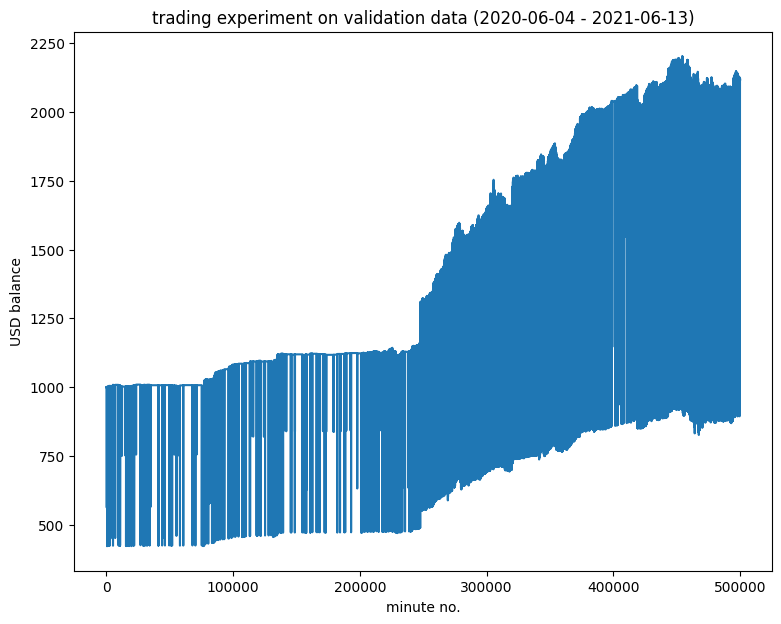

In [221]:
plt.figure(figsize=(9,7))
plt.plot(indices_valid, balances_valid)
start = df_valid.iloc[0]['date'].split()[0]
end = df_valid.iloc[-1]['date'].split()[0]
plt.title(f'trading experiment on validation data ({start} - {end})')
plt.xlabel('minute no.');
plt.ylabel('USD balance');

In [222]:
before = float(valid_tsds.X[0])
after = float(valid_tsds.X[-1])
print(before, after, after/before)
# clearly, just buying and hodling all the way would be better and would leave us
# with 3700 in the bank insead of 2100 yielded by our algorithm
# but short term buying and almost immediate selling can be considered safer
# if you're not a bitcoin maximalist like Michael Saylor

9660.5595703125 35946.9609375 3.721001943610725


## Same but on TEST dataset

In [223]:
test_targets, test_preds = get_all_targets_and_preds(model=net.to('cuda'), dataloader=test_dl)

In [224]:
indices_test, balances_test, log_test = trading_experiment(tsds=test_tsds, preds=test_preds, initial_balance=1000.)

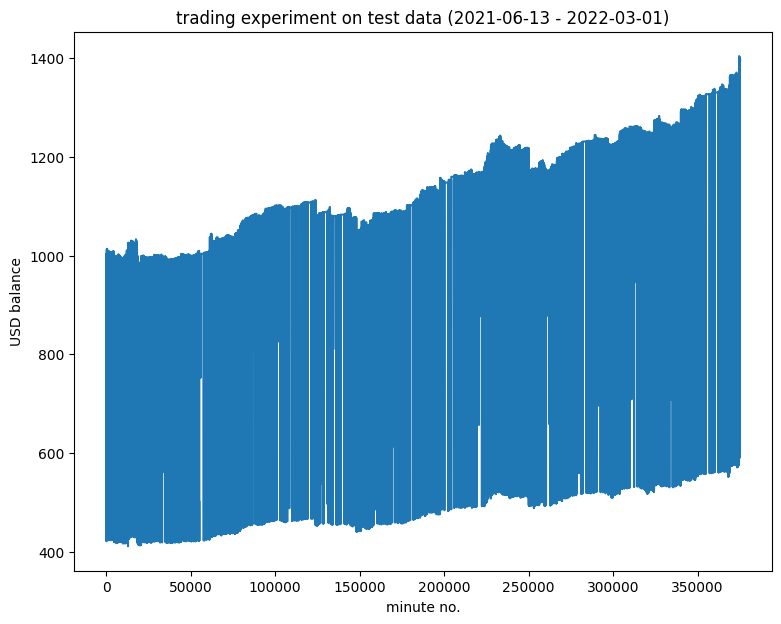

In [213]:
plt.figure(figsize=(9,7))
plt.plot(indices_test, balances_test)
start = df_test.iloc[0]['date'].split()[0]
end = df_test.iloc[-1]['date'].split()[0]
plt.title(f'trading experiment on test data ({start} - {end})')
plt.xlabel('minute no.');
plt.ylabel('USD balance');

In [225]:
# on test, trading with this algorithm would give slighly better returns than maintaining
# a long position all the way through
before = float(test_tsds.X[0])
after = float(test_tsds.X[-1])
before, after, after/before

(35900.3515625, 43046.578125, 1.199057286390606)

## Final considerations

1. **I believe there is no data leak here.** In time series data, and particularly in our case, we have access to all the data up to a point when the model makes the prediction, so the only possible data leak is the type of data leak where the future becomes known to the model. I have done my best to ensure this doesn't happen. 

2. The model is very simple, and there's much space for improvement. **RNNs **such as LSTM or GRU would probably work better, while also being more computationally demanding. What's more important, RNNs would require an even more care and vigilance in terms of forward-looking leaks (discussed just above). I'd be glad to try them instead if you are interested in expanding on this work.

3. Other than improving the architecture of the network, there's another way that could drastically increase the model performance: enriching data. This would include taking **trading volume** into the account, as well as certain repetitive, seasonal patterns (**part of the year, day of the week, time of day**). Finally, taking the very basic **sentiment from twitter** could further improve the model quality, however it's important to notice that our model focuses on very fast-paced trading (2 minutes long positions), so the sentiment would be lagging behind and would be only providing the general atmosphere, similar to the weekday. 

4. It's hard to evaluate whether the model and the trading algorithm based on it has any value, because as shown it is not significantly better than maintaining a long position or HODLing, as they say. The algorithm, of course, could be supercharged and allowed to trade with leverage. **Judging by the roc curve,** I believe my model to be **significantly better than random noise** - again, supposing there are no data leaks that would ruin the whole solution. 

5. The value of the trading algorithm is diminished when we consider actual trading platforms that have **some sorts of fees, commissions, spreads between the buy price and the sell price**, and other forms of financial overhead. With these additional spendings, the net profit from this algorithm could turn out to be negative.

6. It is important to note that **the test dataset** was never used bold text on tuning any parameters or hyperparameters of the neural network or the trading algorithm, and **was only used for the final trading experiment**, thus making the results more trustworthy.